In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from pathlib import Path
from warnings import filterwarnings
import shutil
filterwarnings('ignore')

#### Data Ingestion

In [9]:
train_path=Path("Data/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train")
test_path=Path("temp/Data/test")
validation_path=Path("Data/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid")
DIR_PATHS=[validation_path]
UPLOAD_PATHS=[Path('images/val')]

In [100]:
def Paths_Lables(path,leaf,disease):
    for directories in os.listdir(path):
        sep=directories.split('___')
        leaf.append(sep[0])
        disease.append(sep[1])
    return leaf,disease
print(len(os.listdir(train_path)))

38


#### Reducing Number of Features

In [21]:
def migrate(path1,path2,no):
    n=0
    for directories in os.listdir(path1):
        os.makedirs(os.path.join(path2,directories),exist_ok=True)
        for images in os.listdir(os.path.join(path1,directories)):
            shutil.copy(src=Path(os.path.join(path1,directories,images)),dst=Path(os.path.join(path2,directories,images)))
            n+=1
            if( n==no):
                n=0
                break
        continue
    

In [12]:
migrate(validation_path,'images/val',150)
migrate(train_path,'images/train',400)

### Data Transformation

In [2]:
import tensorflow.keras.preprocessing.image as tfi

In [3]:
datagen=tfi.ImageDataGenerator(rescale=1/255)

In [4]:
tr_path=Path('images/train')
val_path=Path('images/val')

##### Transformed Images

In [5]:
train_gen=datagen.flow_from_directory(tr_path, class_mode="categorical",target_size =(256,256),batch_size = 50,color_mode='rgb',shuffle = True)
valid_gen=datagen.flow_from_directory(val_path,class_mode='categorical',target_size=(256,256),batch_size=50,color_mode='rgb',shuffle=True)

Found 16508 images belonging to 45 classes.
Found 6507 images belonging to 45 classes.


#### Model Training

In [35]:
import tensorflow as tf
from keras.layers import Activation,Dropout,BatchNormalization,Conv2D,AveragePooling2D,GlobalAveragePooling2D,MaxPooling2D,Flatten,Dense
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.initializers import he_normal
import keras

In [40]:
INPUT_SHAPE=(256,256,3)
cb=[EarlyStopping(patience=5),ModelCheckpoint('./checkpoint.weights.h5')]
base_model = tf.keras.applications.MobileNet(weights = "imagenet",
                                             include_top = False,
                                             input_shape = INPUT_SHAPE)

base_model.trainable = False
inputs = keras.Input(shape = INPUT_SHAPE)

x = base_model(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(45, activation="softmax")(x)

model = keras.Model(inputs = inputs, outputs = x, name="LeafDisease_MobileNet")
    
optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer = optimizer,
                  loss = tf.keras.losses.CategoricalCrossentropy(),
                  metrics=[keras.metrics.CategoricalAccuracy(), 
                           'accuracy'])
history = .fit(train_gen,
                    validation_data=valid_gen,
                    epochs=10,
                    steps_per_epoch=150,
                    validation_steps=100,
                       callbacks=cb)

Epoch 1/10
150/150 [==============================] - 224s 1s/step - loss: 1.5691 - categorical_accuracy: 0.6015 - accuracy: 0.6015 - val_loss: 0.5935 - val_categorical_accuracy: 0.8684 - val_accuracy: 0.8684
Epoch 2/10
150/150 [==============================] - 192s 1s/step - loss: 0.5044 - categorical_accuracy: 0.8736 - accuracy: 0.8736 - val_loss: 0.3674 - val_categorical_accuracy: 0.9046 - val_accuracy: 0.9046
Epoch 3/10
150/150 [==============================] - 250s 2s/step - loss: 0.3380 - categorical_accuracy: 0.9113 - accuracy: 0.9113 - val_loss: 0.2836 - val_categorical_accuracy: 0.9268 - val_accuracy: 0.9268
Epoch 4/10
150/150 [==============================] - 212s 1s/step - loss: 0.2567 - categorical_accuracy: 0.9315 - accuracy: 0.9315 - val_loss: 0.2446 - val_categorical_accuracy: 0.9316 - val_accuracy: 0.9316
Epoch 5/10
150/150 [==============================] - 226s 2s/step - loss: 0.2272 - categorical_accuracy: 0.9413 - accuracy: 0.9413 - val_loss: 0.2148 - val_categor

In [8]:
cb=[EarlyStopping(patience=10),ModelCheckpoint('./checkpoint.weights.h5')]

In [59]:
Data=pd.DataFrame(history.history)
Data.drop(["categorical_accuracy","val_categorical_accuracy"],axis=1)

,loss,accuracy,val_loss,val_accuracy
0,1.569136,0.601467,0.593477,0.8684
1,0.504359,0.873600,0.367361,0.9046
2,0.338008,0.911333,0.283623,0.9268
3,0.256659,0.931467,0.244570,0.9316
4,0.227197,0.941271,0.214826,0.9406
5,0.183001,0.954009,0.197833,0.9436
6,0.164139,0.958702,0.185754,0.9490
7,0.149520,0.959467,0.168998,0.9532
8,0.132598,0.964533,0.156431,0.9546
9,0.129448,0.965600,0.143380,0.9578


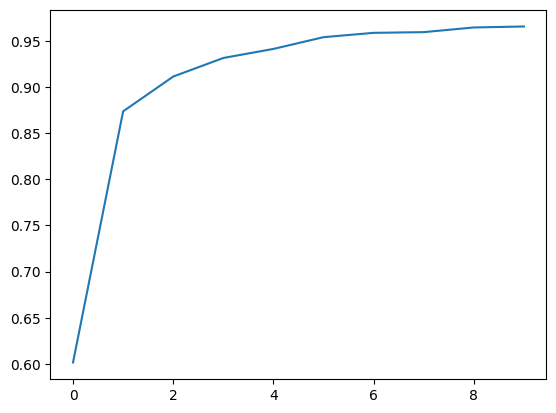

In [68]:
plt.plot(Data['accuracy'])

In [50]:
train_gen.class_indices

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3,
 'Blueberry___healthy': 4,
 'Cherry_(including_sour)___Powdery_mildew': 5,
 'Cherry_(including_sour)___healthy': 6,
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7,
 'Corn_(maize)___Common_rust_': 8,
 'Corn_(maize)___Northern_Leaf_Blight': 9,
 'Corn_(maize)___healthy': 10,
 'Cucumber___Bad': 11,
 'Cucumber___Healthy': 12,
 'Grape___Black_rot': 13,
 'Grape___Esca_(Black_Measles)': 14,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 15,
 'Grape___healthy': 16,
 'Mango___GallMidge': 17,
 'Mango___healthy': 18,
 'Orange___Haunglongbing_(Citrus_greening)': 19,
 'Peach___Bacterial_spot': 20,
 'Peach___healthy': 21,
 'Pepper,_bell___Bacterial_spot': 22,
 'Pepper,_bell___healthy': 23,
 'Potato___Early_blight': 24,
 'Potato___Late_blight': 25,
 'Potato___healthy': 26,
 'Raspberry___healthy': 27,
 'Rice___Healthy': 28,
 'Soybean___healthy': 29,
 'Squash___Powdery_mildew': 30,
 'Straw

#### Model Evaluation

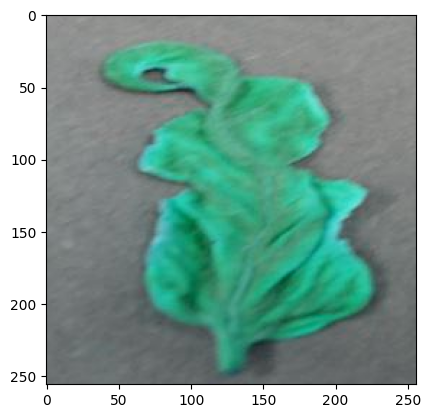

In [106]:
import tensorflow as tf
img=cv2.imread(r"images\test\")
plt.imshow(img)

In [107]:
import tensorflow as tf
img=cv2.imread(r"images\test\TomatoYellowCurlVirus5.JPG")
img.shape

(256, 256, 3)

In [108]:
resize = tf.image.resize(img, (256,256))
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 62ms/step


In [109]:
np.argmax(yhat)

42

In [69]:
import pickle as pkl

In [70]:
pkl.dump(model,open('model.pkl','wb'))